# **Red Hat Open Source Contest**
Implement ML model to identify performance issues in running Indy services, based on aggregated logs + metrics in ElasticSearch. Use the ML model to:

- Predict performance during performance testing executions
- Identify performance bottlenecks and recommend areas to optimize
- Trigger automated investigations when Indy SLOs are breached
- Provide Jupyter notebook containing initial investigation results, linked to the datasets as appropriate

We will provide aggregated log events and/or metric events. Metric events will contain opentracing.io -compatible spans, with ID’s that tie the events together in context. Aggregated log events also contain some contextual information, but there’s a lot of overlap with the metric data. Span data in our metric events will contain measurements from subsystems (and threaded-off sub-processes) for each request. We may also be able to provide aggregated metrics (think Prometheus, not Opentracing) for system-level metrics like memory usage.

You may use the programming language of your choice, but the chosen processing framework must run in an OpenShift environment (Kubernetes with restricted container access / privileges).

#### The Data
Data comprises of two types of json files:
- 23 Kibana logs
- metrics captured

## Kibana Logs

In [2]:
import json
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

path = "./data/LogsAndMetrics"


In [3]:
'''
num_k_logs = 24
Cpde to ceate the kibana log's dataframe
k_logs = []

for i in range(num_k_logs):
    with open(path+"/"+str(i)+"-logs.json") as f:
        log = json.load(f)
    k_logs.append(log)

temp = k_logs[0]
print(type(k_logs[0]))
print(json.dumps(temp[0],indent = 4))
''';

In [50]:
kibana = pd.read_csv("kibana.csv")
kibana.iloc[0]

score                                                           5.0232
type                                                               log
id                                                AXCbMDhAQp1MinEMcxcx
index                                             indy-logs-2020.03.02
thread                                                  XNIO-2 task-12
level                                                            DEBUG
timestamp                                                1583151592248
@timestamp                                    2020-03-02T12:19:53.254Z
context                                                        default
message              BASIC authenticate injector checking for Autho...
pipeline_metadata                             2020-03-02T12:19:53.254Z
version                                                              1
logger               org.commonjava.indy.bind.jaxrs.keycloak.BasicA...
BUILD_COMMIT                  8c867041ff881386dc301df2a72279812f1f51b8
HOSTNA

In [5]:
kibana.shape

(38000, 17)

## metrics.json

In [6]:
with open(path+"\metrics.json") as f:
    metric = json.load(f)

In [7]:
temp = metric["-M1PrTdEUuamuVannCBU"] 
print(json.dumps(json.loads(temp["data"]),indent = 4))

{
    "infinispan.pool.ConnectivityCheck": {
        "healthy": true
    },
    "o.c.i.m.healthcheck.impl.DeadlockHealthCheck": {
        "healthy": true
    },
    "o.c.i.m.healthcheck.impl.HeapHealthCheck": {
        "healthy": true,
        "free-gb": 16.144923210144043,
        "used-gb": 1.855076789855957,
        "max-gb": 18.0,
        "total-gb": 18.0,
        "current-load-pct": 10.305982165866428
    },
    "o.c.i.m.healthcheck.impl.SummaryHealthCheck": {
        "healthy": true,
        "unhealthy-count": 0
    },
    "sli.golden.content": {
        "healthy": true,
        "latency": 68762046.0,
        "errors": 0.0,
        "throughput": 1.8555026160334413e-25,
        "load": 1.8539915306771296e-25
    },
    "sli.golden.content.generic": {
        "healthy": true,
        "latency": 0.0,
        "errors": 0.0,
        "throughput": 0.0,
        "load": 0.0
    },
    "sli.golden.content.listing": {
        "healthy": true,
        "latency": 75976567.0,
        "errors"

# Exploring the data
We first look at the kibana logs.

In [8]:
print("Shape of kibana logs dataframe: "+str(kibana.shape))
print("\nUnique values in each field:")
print(kibana.nunique())

Shape of kibana logs dataframe: (38000, 17)

Unique values in each field:
score                    2
type                     1
id                   38000
index                    2
thread                3901
level                    4
timestamp            25335
@timestamp            4566
context                  1
message              27035
pipeline_metadata     4566
version                  1
logger                  89
BUILD_COMMIT             1
HOSTNAME                 1
NAMESPACE                1
POD_NAME                 3
dtype: int64


In [53]:
display(kibana.iloc[0])

score                                                           5.0232
type                                                               log
id                                                AXCbMDhAQp1MinEMcxcx
index                                             indy-logs-2020.03.02
thread                                                  XNIO-2 task-12
level                                                            DEBUG
timestamp                                                1583151592248
@timestamp                                    2020-03-02T12:19:53.254Z
context                                                        default
message              BASIC authenticate injector checking for Autho...
pipeline_metadata                             2020-03-02T12:19:53.254Z
version                                                              1
logger               org.commonjava.indy.bind.jaxrs.keycloak.BasicA...
BUILD_COMMIT                  8c867041ff881386dc301df2a72279812f1f51b8
HOSTNA

Immediately we see that there are 38000 logs recorded in 24 hours, and we captures 17 different parameters with each record. Additionally the dataset has no null values in any of the logs.

On viewing the number of unique values in each field we get a better idea of which fields are more interesting - in our case the fields 'type', 'context', 'version', 'BUILD_COMMIT', 'HOSTNAME', 'NAMESPACE' all have only one value and hence aren't providing any useful information, hence we may ignore them. We will further study each of these remaining features individually.

## Score
Score field has two values with counts 26233 and 11767 respectively.

In [9]:
print(kibana.score.value_counts())

5.023198    26233
2.921741    11767
Name: score, dtype: int64


## Id
Id seems to be the unique id given to each log event. It is also the only field with unique values in the logs.

In [10]:
print("Examples of ids include:")
print(kibana.id.head())

Examples of ids include:
0    AXCbMDhAQp1MinEMcxcx
1    AXCbMDhAQp1MinEMcxcy
2    AXCbMUlGQp1MinEMczao
3    AXCbMUlGQp1MinEMczap
4    AXCbMUlGQp1MinEMczaq
Name: id, dtype: object


## Index
Index seems to have 2 unique values which seems reasonable considering that the format for index is "indy-logs-(logs_date)" and we have data that spans across a 24 hour period, ie. we have logs corresponding to 2nd and 3rd March, with most of the logs coming from March 2nd.

In [11]:
print(kibana["index"].value_counts())

indy-logs-2020.03.02    26233
indy-logs-2020.03.03    11767
Name: index, dtype: int64


Another thing that we note is that these counts are the same as that of score. Further analysis might show that these are correlated, thus score might be evaluated daily is same for all records of the same day.

## Thread
Thread seems interesting with only 3901 unique values. From initial observations most of the unique values come from the different URLs/tasks at the end of the entries, so we will try to view how many types of thread field values.

In [12]:
def thread_clean(thread_type):
    thread_type = thread_type.split(" ")[0].split(":")[0]
    thread_type = re.sub("-(\d)+","",thread_type)
    return thread_type
    
temp = "XNIO-2 task-12"
print("Original: " + temp + ",\tAfter cleaning: "+thread_clean(temp))

thread_type = kibana.apply(lambda x: thread_clean(x["thread"]),axis=1)

Original: XNIO-2 task-12,	After cleaning: XNIO


In [13]:
print("There are "+str(len(thread_type))+" types of threads logged in our data.\n")
print("Counts of the unique thread types: \n"+str(thread_type.value_counts()))

There are 38000 types of threads logged in our data.

Counts of the unique thread types: 
expiration-thread--p3-t1            9681
GET                                 9164
main                                8629
XNIO                                5091
store-affected-by-async-runner      1779
PUT                                 1684
metrics-graphite-reporter-thread     653
maven-metadata-generator             345
HEAD                                 243
promotion-transfers                  181
promotion                            172
POST                                  92
galley-transfers                      78
DELETE                                74
content-cleanup                       46
POST-DELETE-EVENT                     39
indy-event-dispatch                   26
cluster1-nio-worker                   13
store-validation                      10
dtype: int64


## Level
This field denotes the level of the thread. We have 4 types of thread levels - INFO, DEBUG, WARN and ERROR. Naturally the debug and info logs far out-number the warn and error logs.

In [14]:
print("Unique value counts:\n\n"+str(kibana["level"].value_counts()))

Unique value counts:

INFO     29219
DEBUG     8365
WARN       368
ERROR       48
Name: level, dtype: int64


## Message
Contains the message of the log. Text content varies greatly, even removing URLs as done later still results in 300 unique messages. Maybe splitting further based on level might help.

In [15]:
m = kibana.apply(lambda x: x["message"].split(":")[0],axis=1)
print("Number of unique messages after cleaning: "+str(m.nunique()))

Number of unique messages after cleaning: 300


In [16]:
print("Unique message counts:")
m.value_counts()

Unique message counts:


Starting delete of                                                                                                                                                                                                                            5297
Finished delete of                                                                                                                                                                                                                            5293
Removed affected-by reverse mapping for                                                                                                                                                                                                       4226
Added affected-by reverse mapping for                                                                                                                                                                                                         4224
BASIC authenticate injector 

In [17]:
for i in m:
    if "Fail" in i:
        pass
        #print(i)
        #print("\n")

## Timestamp, @timestamp and pipeline_metadata
We will analyse these three timestamp data fields together.
Timestamp has 25000 records which are in standard timestamp format. Pipeline_metadata and @timestamp are textual data with both having 4566 unique values.

In [18]:
def timestamp_clean(ts):
    s, ms = divmod(int(ts), 1000)
    return '%s.%03d' % (time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(s)), ms)

kibana["timestamp_cleaned"] = kibana.apply(lambda x: timestamp_clean(int(x["timestamp"])), axis=1)
print(kibana[["timestamp_cleaned","@timestamp","pipeline_metadata"]].head())

kibana.drop("timestamp_cleaned",axis=1, inplace=True) # column was only created as a temporary field, so we drop it now

         timestamp_cleaned                @timestamp         pipeline_metadata
0  2020-03-02 12:19:52.248  2020-03-02T12:19:53.254Z  2020-03-02T12:19:53.254Z
1  2020-03-02 12:19:52.248  2020-03-02T12:19:53.254Z  2020-03-02T12:19:53.254Z
2  2020-03-02 12:21:02.247  2020-03-02T12:21:03.255Z  2020-03-02T12:21:03.255Z
3  2020-03-02 12:21:02.247  2020-03-02T12:21:03.255Z  2020-03-02T12:21:03.255Z
4  2020-03-02 12:21:03.237  2020-03-02T12:21:03.255Z  2020-03-02T12:21:03.255Z


From the above we find that the pipeline_metadata("recieved at") and @timestamp fields are identical. On converting timestamp to date format we can see that the values in '@timestamp' seem to be milliseconds ahead of 'timestamp' field in all cases.

In [19]:
kibana.POD_NAME.value_counts()

indy-163-hgs9m          20288
indy-164-5wcgh          10931
indy-static-58-wbm72     6781
Name: POD_NAME, dtype: int64

In [20]:
kibana.logger.value_counts()

org.commonjava.topic.content.delete                                                      10607
org.commonjava.indy.infinispan.data.InfinispanStoreDataManager$Proxy$_$$_WeldSubclass     8497
org.commonjava.indy.bind.jaxrs.keycloak.BasicAuthenticationOAuthTranslator                4586
org.commonjava.topic.rest.inbound                                                         3801
org.commonjava.indy.db.common.DefaultArtifactStoreQuery                                   2243
                                                                                         ...  
com.datastax.driver.core.NettyUtil                                                           1
org.commonjava.maven.galley.io.SpecialPathManagerImpl                                        1
org.commonjava.indy.core.data.StoreDataSetupAction                                           1
org.infinispan.transaction.lookup.GenericTransactionManagerLookup                            1
org.commonjava.indy.infinispan.data.InfinispanStor

# Metrics
We will now take a look at the metrics file in this section.

In [21]:
keys = list(metric.keys())

print("Number of metric logs: " + str(len(metric.keys())))
print("Keys in each metric log: "+str(metric[keys[0]].keys()))

Number of metric logs: 95000
Keys in each metric log: dict_keys(['data', 'timestamp'])


We see that there are 95000 records of metrics taken. Presumably one metric is taken per second so we have slightly more than 1 days worth of data if there are no duplicates. The data consists of a 'timestamp' field and a data section which contains a json containing information about the state of the current processes. We first explore the timestamps and then we will take a look at the data field in the following sections.

In [22]:
print("First 5 timestamps: ")
for i in range(5):
    print(str(i)+": "+str(timestamp_clean(metric[keys[i]]["timestamp"])))
    
print("\nLast 5 timestamps: ")
for i in range(5,0,-1):
    print(str(len(keys)-i)+": "+str(timestamp_clean(metric[keys[len(keys) - i]]["timestamp"])))

First 5 timestamps: 
0: 2020-03-02 10:49:59.151
1: 2020-03-02 10:50:00.148
2: 2020-03-02 10:50:01.154
3: 2020-03-02 10:50:02.153
4: 2020-03-02 10:50:03.153

Last 5 timestamps: 
94995: 2020-03-03 13:21:22.789
94996: 2020-03-03 13:21:23.792
94997: 2020-03-03 13:21:24.789
94998: 2020-03-03 13:21:25.790
94999: 2020-03-03 13:21:26.795


From the above data we see that the metrics are ordered by their timestamps. The recordings are taken in almost equal time intervals of approximately 1 second. From the beginning and end timestamps we see that the data being collected starts from 10:50 am on 2nd March and stops recording at 1:21 pm on 3rd March, which should correspond to ~95,427 records or in our case 95,000 records.
Not shown, but 2nd March has 47176 leaving 3rd March with 47824 records.

In [23]:
metric_data = []
timestamps = []

for key in keys:
    metric_data.append(json.loads(metric[key]["data"])) 
    timestamps.append((metric[key]["timestamp"]))

In [24]:
processes = list(metric_data[0].keys())
metric_df = pd.DataFrame()
metric_columns = []

for process in processes:
        process_fields = list(metric_data[0][process].keys())
        for process_field in process_fields:
            metric_columns.append(str(process + "_" + process_field))

In [25]:
'''
Code to create the metrics DataFrame

for i in range(len(metric_data)):
    entry = []
        print(i)
    for process in processes:
        process_fields = list(metric_data[0][process].keys())
        if process in metric_data[i].keys():
            for process_field in process_fields:
                entry.append(metric_data[i][process][process_field])
        else:
            for process_field in process_fields:
                entry.append(None)
                
    metric_df = metric_df.append([entry])
print(metric_df.shape())

metric_df.to_csv("metric_df.csv", index = False); to write the data to a CSV when first creating the DataFrame
''';

'\nCode to create the metrics DataFrame\n\nfor i in range(len(metric_data)):\n    entry = []\n        print(i)\n    for process in processes:\n        process_fields = list(metric_data[0][process].keys())\n        if process in metric_data[i].keys():\n            for process_field in process_fields:\n                entry.append(metric_data[i][process][process_field])\n        else:\n            for process_field in process_fields:\n                entry.append(None)\n                \n    metric_df = metric_df.append([entry])\nprint(metric_df.shape())\n\nmetric_df.to_csv("metric_df.csv", index = False); to write the data to a CSV when first creating the DataFrame\n'

In [26]:
metric_df = pd.read_csv("metric_df.csv")

final_columns = [] # will append relevant columns for training on, to final_columns
metric_df.shape

c:\users\schub\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (85,89,97,101,105,113,121,129,133,137,141,145,149) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(95000, 162)

In [51]:
metric_df.head()

,infinispan.pool.ConnectivityCheck_healthy,o.c.i.m.healthcheck.impl.DeadlockHealthCheck_healthy,o.c.i.m.healthcheck.impl.HeapHealthCheck_healthy,o.c.i.m.healthcheck.impl.HeapHealthCheck_free-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_max-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_total-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_current-load-pct,o.c.i.m.healthcheck.impl.SummaryHealthCheck_healthy,o.c.i.m.healthcheck.impl.SummaryHealthCheck_unhealthy-count,...,weft.ThreadPoolExecutor.rescan-manager.rescan-manager_load-factor,weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_healthy,weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_pool-size,weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_current-load,weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_load-factor,weft.ThreadPoolExecutor.store-validation.store-validation_healthy,weft.ThreadPoolExecutor.store-validation.store-validation_pool-size,weft.ThreadPoolExecutor.store-validation.store-validation_current-load,weft.ThreadPoolExecutor.store-validation.store-validation_load-factor,timestamp
0,True,True,True,16.144923,1.855077,18.0,18.0,10.305982,True,0,...,0.0,True,200,0,0.0,True,2,0,0.0,1583146199151
1,True,True,True,15.985740,2.014260,18.0,18.0,11.190331,True,0,...,0.0,True,200,0,0.0,True,2,0,0.0,1583146200148
2,True,True,True,17.620493,0.379507,18.0,18.0,2.108372,True,0,...,0.0,True,200,0,0.0,True,2,0,0.0,1583146201154
3,True,True,True,17.459361,0.540639,18.0,18.0,3.003549,True,0,...,0.0,True,200,0,0.0,True,2,0,0.0,1583146202153
4,True,True,True,17.292365,0.707635,18.0,18.0,3.931306,True,0,...,0.0,True,200,0,0.0,True,2,0,0.0,1583146203153


Now we shall explore the above collected metric data in a process-wise manner to see what we may learn.

### infinispan.pool.ConnectivityCheck and o.c.i.m.healthcheck.impl process metrics

In [27]:
required_cols = metric_columns[0:10]
required_df = metric_df[required_cols]

display(required_df.head())

,infinispan.pool.ConnectivityCheck_healthy,o.c.i.m.healthcheck.impl.DeadlockHealthCheck_healthy,o.c.i.m.healthcheck.impl.HeapHealthCheck_healthy,o.c.i.m.healthcheck.impl.HeapHealthCheck_free-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_max-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_total-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_current-load-pct,o.c.i.m.healthcheck.impl.SummaryHealthCheck_healthy,o.c.i.m.healthcheck.impl.SummaryHealthCheck_unhealthy-count
0,True,True,True,16.144923,1.855077,18.0,18.0,10.305982,True,0
1,True,True,True,15.985740,2.014260,18.0,18.0,11.190331,True,0
2,True,True,True,17.620493,0.379507,18.0,18.0,2.108372,True,0
3,True,True,True,17.459361,0.540639,18.0,18.0,3.003549,True,0
4,True,True,True,17.292365,0.707635,18.0,18.0,3.931306,True,0


In [28]:
print("Unique value counts:")
display(required_df.nunique())

Unique value counts:


infinispan.pool.ConnectivityCheck_healthy                          1
o.c.i.m.healthcheck.impl.DeadlockHealthCheck_healthy               1
o.c.i.m.healthcheck.impl.HeapHealthCheck_healthy                   1
o.c.i.m.healthcheck.impl.HeapHealthCheck_free-gb               94975
o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb               94975
o.c.i.m.healthcheck.impl.HeapHealthCheck_max-gb                    1
o.c.i.m.healthcheck.impl.HeapHealthCheck_total-gb                  1
o.c.i.m.healthcheck.impl.HeapHealthCheck_current-load-pct      94975
o.c.i.m.healthcheck.impl.SummaryHealthCheck_healthy                1
o.c.i.m.healthcheck.impl.SummaryHealthCheck_unhealthy-count        1
dtype: int64

Of the above process metrics recorded we see that all but 3 of the columns have only 1 unique value thus it will only be these three columns that will prove to be useful for a statistical model.
Furthermore, of these three columns we note that it is quite interesting that they all have the exact same number of unique values which tells us that they might be correlated in some manner.

In [29]:
print("Free-gb and Used-gb columns")
print("Addition of the above columns: ")

temp = pd.DataFrame()
temp["o.c.i.m.healthcheck.impl.HeapHealthCheck_free-gb"] = metric_df["o.c.i.m.healthcheck.impl.HeapHealthCheck_free-gb"]
temp["o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb"] = metric_df["o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb"]
temp["Sum"] = (required_df["o.c.i.m.healthcheck.impl.HeapHealthCheck_free-gb"]+required_df["o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb"])
display(temp.head())

Free-gb and Used-gb columns
Addition of the above columns: 


,o.c.i.m.healthcheck.impl.HeapHealthCheck_free-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb,Sum
0,16.144923,1.855077,18.0
1,15.985740,2.014260,18.0
2,17.620493,0.379507,18.0
3,17.459361,0.540639,18.0
4,17.292365,0.707635,18.0


In [30]:
print("Which falls in line with the mentioned values of the total-gb available.\n")

print("We now look at the third column of interest - current_load_pct. Which on inspecting we realise is simply used-gb divided by free-gb.")
temp = pd.DataFrame()
temp["used-gb / free-gb"] = 100 * required_df["o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb"]/required_df["o.c.i.m.healthcheck.impl.HeapHealthCheck_total-gb"]
temp["o.c.i.m.healthcheck.impl.HeapHealthCheck_current-load-pct"] = metric_df["o.c.i.m.healthcheck.impl.HeapHealthCheck_current-load-pct"]

display(temp.head())

Which falls in line with the mentioned values of the total-gb available.

We now look at the third column of interest - current_load_pct. Which on inspecting we realise is simply used-gb divided by free-gb.


,used-gb / free-gb,o.c.i.m.healthcheck.impl.HeapHealthCheck_current-load-pct
0,10.305982,10.305982
1,11.190331,11.190331
2,2.108372,2.108372
3,3.003549,3.003549
4,3.931306,3.931306


From the above exploration we find that in these 10 fields no more than 3 are actually useful - and even of these three fields, "free-gb" and "used-gb" can be derieved from one another and the "load-pct" is simply extracted as a percentage of the two former fields. So we will not use all of them together.

In [31]:
final_columns.extend(['o.c.i.m.healthcheck.impl.HeapHealthCheck_current-load-pct','o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb'])

### sli.golden.content and sli.golden.content metrics

In [32]:
required_cols = metric_columns[10:20]
required_df = metric_df[required_cols]
display(required_df.head())
print("\nNumber of unique values in each column: ")
required_df.nunique()

,sli.golden.content_healthy,sli.golden.content_latency,sli.golden.content_errors,sli.golden.content_throughput,sli.golden.content_load,sli.golden.content.generic_healthy,sli.golden.content.generic_latency,sli.golden.content.generic_errors,sli.golden.content.generic_throughput,sli.golden.content.generic_load
0,True,68762046.0,0.0,1.855503e-25,1.853992e-25,True,0.0,0.0,0.0,0.0
1,True,68762046.0,0.0,1.855503e-25,1.853992e-25,True,0.0,0.0,0.0,0.0
2,True,68762046.0,0.0,1.707145e-25,1.705755e-25,True,0.0,0.0,0.0,0.0
3,True,68762046.0,0.0,1.707145e-25,1.705755e-25,True,0.0,0.0,0.0,0.0
4,True,68762046.0,0.0,1.707145e-25,1.705755e-25,True,0.0,0.0,0.0,0.0



Number of unique values in each column: 


sli.golden.content_healthy                   1
sli.golden.content_latency                 713
sli.golden.content_errors                    1
sli.golden.content_throughput            18951
sli.golden.content_load                  18953
sli.golden.content.generic_healthy           1
sli.golden.content.generic_latency           1
sli.golden.content.generic_errors            1
sli.golden.content.generic_throughput        1
sli.golden.content.generic_load              1
dtype: int64

Thus we have only 3 fields with more than one unique value, thus we will only use these in our model. We will explore these three fields more in-depth in the next section.

The correlation between the throughput and load is: 0.9999832038203331
The correlation between the throughput and latency is: -0.14431527835927963

Statistics of sli.golden.content_latency
count    9.500000e+04
mean     1.799876e+10
std      2.504744e+10
min      0.000000e+00
25%      1.363396e+09
50%      7.203138e+09
75%      1.502125e+10
max      6.390337e+10
Name: sli.golden.content_latency, dtype: float64


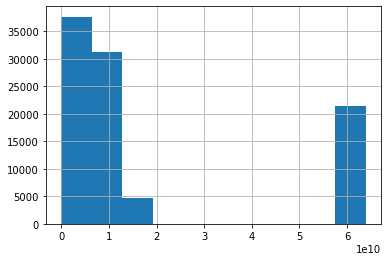

In [33]:
corr = required_df["sli.golden.content_throughput"].corr(required_df["sli.golden.content_load"])
print("The correlation between the throughput and load is: "+str(corr))

corr = required_df["sli.golden.content_throughput"].corr(required_df["sli.golden.content_latency"])
print("The correlation between the throughput and latency is: "+str(corr))

print("\nStatistics of sli.golden.content_latency")
print(required_df["sli.golden.content_latency"].describe())
required_df["sli.golden.content_latency"].hist(bins=10)
plt.show()

Hence we shall only use the throughput and latency columns and we will discard the rest.

In [34]:
final_columns.extend(['sli.golden.content_latency','sli.golden.content_throughput'])

## sli.golden.content processes
With 75 fields in this area, we split it into manageable chunks that we can analyse.


In [35]:
required_cols = metric_columns[20:50]
required_df = metric_df[required_cols]
display(required_df.head())

print("Number of unique values in each column: ")
print(required_df.nunique())

,sli.golden.content.listing_healthy,sli.golden.content.listing_latency,sli.golden.content.listing_errors,sli.golden.content.listing_throughput,sli.golden.content.listing_load,sli.golden.content.maven_healthy,sli.golden.content.maven_latency,sli.golden.content.maven_errors,sli.golden.content.maven_throughput,sli.golden.content.maven_load,...,sli.golden.maven.upload_healthy,sli.golden.maven.upload_latency,sli.golden.maven.upload_errors,sli.golden.maven.upload_throughput,sli.golden.maven.upload_load,sli.golden.metadata_healthy,sli.golden.metadata_latency,sli.golden.metadata_errors,sli.golden.metadata_throughput,sli.golden.metadata_load
0,True,75976567.0,2.308646e-28,9.234585e-28,9.234585e-28,True,66240269.0,0.0,1.855503e-25,1.853992e-25,...,True,71609541.0,0.0,3.186085e-27,3.186085e-27,True,3.060964e+10,0.0,4.824664e-13,3.873214e-13
1,True,75976567.0,2.308646e-28,9.234585e-28,9.234585e-28,True,66240269.0,0.0,1.855503e-25,1.853992e-25,...,True,71609541.0,0.0,3.186085e-27,3.186085e-27,True,3.060964e+10,0.0,4.824664e-13,3.873214e-13
2,True,75976567.0,2.124057e-28,8.496228e-28,8.496228e-28,True,66240269.0,0.0,1.707145e-25,1.705755e-25,...,True,71609541.0,0.0,2.931340e-27,2.931340e-27,True,3.060964e+10,0.0,4.438905e-13,3.563529e-13
3,True,75976567.0,2.124057e-28,8.496228e-28,8.496228e-28,True,66240269.0,0.0,1.707145e-25,1.705755e-25,...,True,71609541.0,0.0,2.931340e-27,2.931340e-27,True,3.060964e+10,0.0,4.438905e-13,3.563529e-13
4,True,75976567.0,2.124057e-28,8.496228e-28,8.496228e-28,True,66240269.0,0.0,1.707145e-25,1.705755e-25,...,True,71609541.0,0.0,2.931340e-27,2.931340e-27,True,3.060964e+10,0.0,4.438905e-13,3.563529e-13


Number of unique values in each column: 
sli.golden.content.listing_healthy           1
sli.golden.content.listing_latency          14
sli.golden.content.listing_errors         9368
sli.golden.content.listing_throughput    15449
sli.golden.content.listing_load          15449
sli.golden.content.maven_healthy             1
sli.golden.content.maven_latency           713
sli.golden.content.maven_errors              1
sli.golden.content.maven_throughput      18951
sli.golden.content.maven_load            18953
sli.golden.content.npm_healthy               1
sli.golden.content.npm_latency               1
sli.golden.content.npm_errors                1
sli.golden.content.npm_throughput            1
sli.golden.content.npm_load                  1
sli.golden.maven.download_healthy            1
sli.golden.maven.download_latency         1296
sli.golden.maven.download_errors             1
sli.golden.maven.download_throughput      7677
sli.golden.maven.download_load           10786
sli.golden.maven.up

From the above we see that all 6 processes have only one unique value for their 'healthy' and 'error'(except for sli.golden.content.listing having 9368 error values). Also npm has each of its columns with only a single unique value.

In [36]:
columns = required_df.nunique()[(required_df.nunique() > 1) == True].keys()
display(columns)
display(len(columns))
required_df[columns].describe()

Index(['sli.golden.content.listing_latency',
       'sli.golden.content.listing_errors',
       'sli.golden.content.listing_throughput',
       'sli.golden.content.listing_load', 'sli.golden.content.maven_latency',
       'sli.golden.content.maven_throughput', 'sli.golden.content.maven_load',
       'sli.golden.maven.download_latency',
       'sli.golden.maven.download_throughput',
       'sli.golden.maven.download_load', 'sli.golden.maven.upload_latency',
       'sli.golden.maven.upload_throughput', 'sli.golden.maven.upload_load',
       'sli.golden.metadata_latency', 'sli.golden.metadata_throughput',
       'sli.golden.metadata_load'],
      dtype='object')

16

,sli.golden.content.listing_latency,sli.golden.content.listing_errors,sli.golden.content.listing_throughput,sli.golden.content.listing_load,sli.golden.content.maven_latency,sli.golden.content.maven_throughput,sli.golden.content.maven_load,sli.golden.maven.download_latency,sli.golden.maven.download_throughput,sli.golden.maven.download_load,sli.golden.maven.upload_latency,sli.golden.maven.upload_throughput,sli.golden.maven.upload_load,sli.golden.metadata_latency,sli.golden.metadata_throughput,sli.golden.metadata_load
count,9.500000e+04,9.500000e+04,9.500000e+04,9.500000e+04,9.500000e+04,9.500000e+04,9.500000e+04,9.500000e+04,95000.000000,95000.000000,9.500000e+04,9.500000e+04,9.500000e+04,9.500000e+04,95000.000000,95000.000000
mean,1.907549e+08,4.195915e-05,3.252367e-04,3.252367e-04,1.799887e+10,3.092833e-01,3.092888e-01,1.784849e+09,0.324716,0.324718,8.869503e+07,3.420565e-02,3.420550e-02,1.799323e+09,0.050165,0.050166
std,2.336245e+08,5.903880e-04,3.056184e-03,3.056184e-03,2.504737e+10,1.432434e+00,1.432636e+00,6.218404e+09,1.378597,1.378667,7.262562e+07,2.378215e-01,2.377202e-01,6.258989e+09,0.220300,0.220404
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3.122378e+07,5.364846e-193,2.030577e-93,2.030577e-93,1.363396e+09,1.120376e-73,1.075940e-73,1.061261e+08,0.011950,0.011950,2.448502e+07,2.389602e-87,2.220453e-87,1.047615e+08,0.011950,0.011950
50%,9.160570e+07,1.021867e-106,2.688446e-51,2.688446e-51,7.203138e+09,4.491024e-36,4.393368e-36,1.261069e+08,0.016677,0.016677,7.160954e+07,4.979476e-45,4.581339e-45,1.224257e+08,0.016677,0.016677
75%,1.636813e+08,1.002447e-47,5.163421e-24,5.163421e-24,1.502125e+10,8.297063e-12,8.136787e-12,4.250572e+08,0.023275,0.023275,1.904684e+08,3.360222e-19,3.166554e-19,1.976352e+08,0.021414,0.021414
max,6.171574e+08,1.599112e-02,6.841975e-02,6.841975e-02,6.390337e+10,1.966025e+01,1.964271e+01,3.060964e+10,19.480331,19.465830,7.047795e+08,5.037651e+00,5.032635e+00,3.060964e+10,3.821520,3.828849


To gain a better understanding, we show the correlation between all of these below.

In our case some of the more interesting relations have a correlation of 0.8 or higher. 

We note that in each process the throughput and load fields are highly correlated and in a lot of the cases the latencies in each process seem to be correlated with one another.

We also see that the only case with multiple error vlaues('..content.listing') is highly correlated with throughout and load and hence may be a result of the same.

'.content.listing_latency','content.maven_latency' and '.content.maven.upload_latency' are all highly correlated.

Similarly we also see that 'sli.maven.download_latency' and 'sli.golde.metadata_latency' show high correlation.

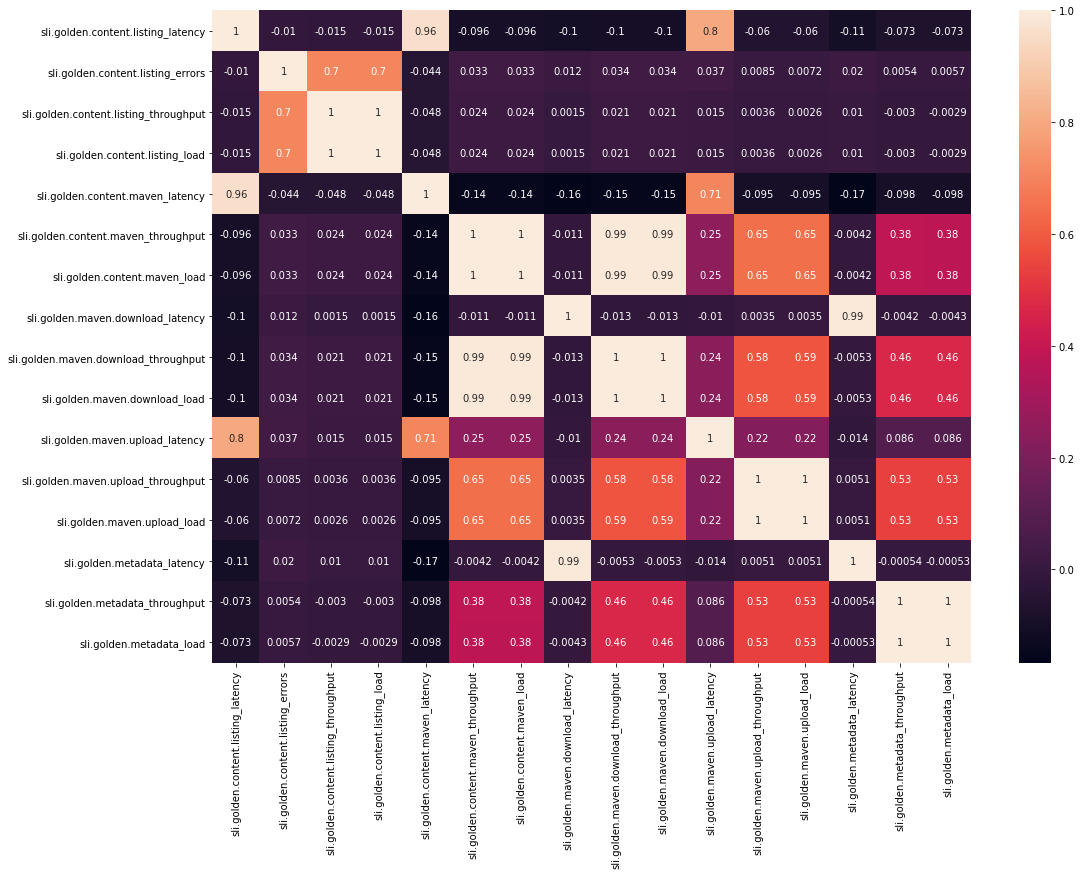

In [37]:
plt.rcParams['figure.figsize'] = [17, 12]
display(sns.heatmap(required_df[columns].corr(),annot=True))
plt.show()

In [38]:
final_columns.extend(['sli.golden.content.listing_latency','sli.golden.content.listing_errors','sli.golden.content.listing_throughput','sli.golden.content.maven_throughput','sli.golden.maven.download_latency','sli.golden.maven.download_throughput','sli.golden.maven.upload_latency','sli.golden.maven.upload_throughput','sli.golden.metadata_latency','sli.golden.metadata_throughput'])

In [61]:
required_cols = metric_columns[50:85] # till col 85, the last of the sli. columns
required_df = metric_df[required_cols]
display(required_df.head())

print("Number of unique values in each column: ")
print(required_df.nunique())

,sli.golden.metadata.maven_healthy,sli.golden.metadata.maven_latency,sli.golden.metadata.maven_errors,sli.golden.metadata.maven_throughput,sli.golden.metadata.maven_load,sli.golden.metadata.npm_healthy,sli.golden.metadata.npm_latency,sli.golden.metadata.npm_errors,sli.golden.metadata.npm_throughput,sli.golden.metadata.npm_load,...,sli.golden.npm.upload_healthy,sli.golden.npm.upload_latency,sli.golden.npm.upload_errors,sli.golden.npm.upload_throughput,sli.golden.npm.upload_load,sli.golden.promotion_healthy,sli.golden.promotion_latency,sli.golden.promotion_errors,sli.golden.promotion_throughput,sli.golden.promotion_load
0,True,3.060964e+10,0.0,4.824664e-13,3.873214e-13,True,0.0,0.0,0.0,0.0,...,True,0.0,0.0,0.0,0.0,True,1.033696e+11,0.0,1.560133e-27,4.617292e-28
1,True,3.060964e+10,0.0,4.824664e-13,3.873214e-13,True,0.0,0.0,0.0,0.0,...,True,0.0,0.0,0.0,0.0,True,1.033696e+11,0.0,1.560133e-27,4.617292e-28
2,True,3.060964e+10,0.0,4.438905e-13,3.563529e-13,True,0.0,0.0,0.0,0.0,...,True,0.0,0.0,0.0,0.0,True,1.033696e+11,0.0,1.435391e-27,4.248114e-28
3,True,3.060964e+10,0.0,4.438905e-13,3.563529e-13,True,0.0,0.0,0.0,0.0,...,True,0.0,0.0,0.0,0.0,True,1.033696e+11,0.0,1.435391e-27,4.248114e-28
4,True,3.060964e+10,0.0,4.438905e-13,3.563529e-13,True,0.0,0.0,0.0,0.0,...,True,0.0,0.0,0.0,0.0,True,1.033696e+11,0.0,1.435391e-27,4.248114e-28


Number of unique values in each column: 
sli.golden.metadata.maven_healthy           1
sli.golden.metadata.maven_latency         625
sli.golden.metadata.maven_errors            1
sli.golden.metadata.maven_throughput     5713
sli.golden.metadata.maven_load           8842
sli.golden.metadata.npm_healthy             1
sli.golden.metadata.npm_latency             1
sli.golden.metadata.npm_errors              1
sli.golden.metadata.npm_throughput          1
sli.golden.metadata.npm_load                1
sli.golden.npm.download_healthy             1
sli.golden.npm.download_latency             1
sli.golden.npm.download_errors              1
sli.golden.npm.download_throughput          1
sli.golden.npm.download_load                1
sli.golden.npm.upload_healthy               1
sli.golden.npm.upload_latency               1
sli.golden.npm.upload_errors                1
sli.golden.npm.upload_throughput            1
sli.golden.npm.upload_load                  1
sli.golden.promotion_healthy           

In [62]:
columns = required_df.nunique()[(required_df.nunique() > 1) == True].keys()
display(columns)
display(len(columns))

Index(['sli.golden.metadata.maven_latency',
       'sli.golden.metadata.maven_throughput',
       'sli.golden.metadata.maven_load', 'sli.golden.promotion_latency',
       'sli.golden.promotion_throughput', 'sli.golden.promotion_load'],
      dtype='object')

6

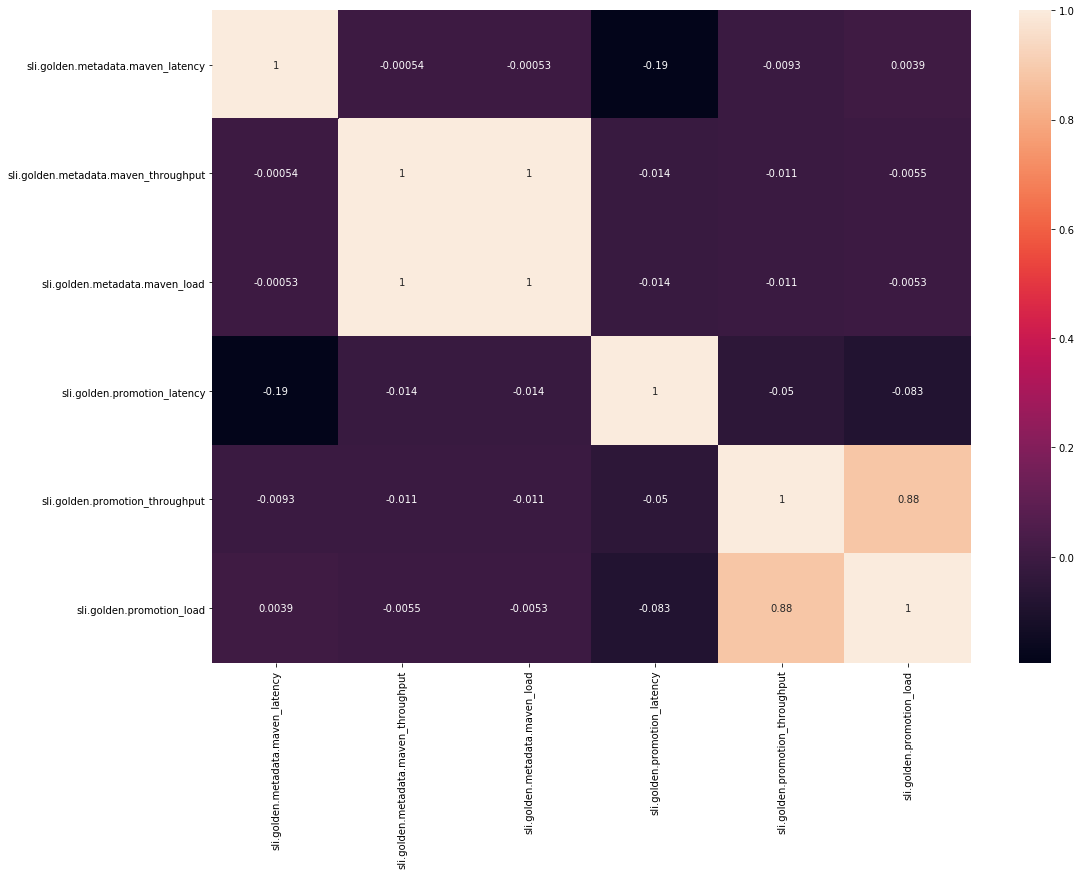

In [63]:
display(sns.heatmap(required_df[columns].corr(),annot=True))

In [42]:
final_columns.extend(['sli.golden.metadata.maven_latency','sli.golden.metadata.maven_throughput','sli.golden.promotion_latency','sli.golden.promotion_throughput','sli.golden.promotion_load','sli.golden.repo.mgmt_latency','sli.golden.repo.mgmt_throughput','sli.golden.tracking.record_latency','sli.golden.tracking.record_throughput','sli.golden.tracking.record_load'])

Again we find similar results in that the latency and throughputs tend to be highly correlated to on another. We will now consider the last section consisting of the .weft processes to see what we may find.

In [43]:
required_cols = metric_columns[85:] # till the last of the sli columns
required_df = metric_df[required_cols]
display(required_df.head())

,weft.ThreadPoolExecutor.Prefetch-Worker.Prefetch-Worker_healthy,weft.ThreadPoolExecutor.Prefetch-Worker.Prefetch-Worker_pool-size,weft.ThreadPoolExecutor.Prefetch-Worker.Prefetch-Worker_current-load,weft.ThreadPoolExecutor.Prefetch-Worker.Prefetch-Worker_load-factor,weft.ThreadPoolExecutor.content-cleanup.content-cleanup_healthy,weft.ThreadPoolExecutor.content-cleanup.content-cleanup_pool-size,weft.ThreadPoolExecutor.content-cleanup.content-cleanup_current-load,weft.ThreadPoolExecutor.content-cleanup.content-cleanup_load-factor,weft.ThreadPoolExecutor.content-index-warmer.content-index-warmer_healthy,weft.ThreadPoolExecutor.content-index-warmer.content-index-warmer_pool-size,...,weft.ThreadPoolExecutor.rescan-manager.rescan-manager_current-load,weft.ThreadPoolExecutor.rescan-manager.rescan-manager_load-factor,weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_healthy,weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_pool-size,weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_current-load,weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_load-factor,weft.ThreadPoolExecutor.store-validation.store-validation_healthy,weft.ThreadPoolExecutor.store-validation.store-validation_pool-size,weft.ThreadPoolExecutor.store-validation.store-validation_current-load,weft.ThreadPoolExecutor.store-validation.store-validation_load-factor
0,True,5.0,0.0,0.0,True,200.0,0.0,0.0,True,12,...,0.0,0.0,True,200,0,0.0,True,2,0,0.0
1,True,5.0,0.0,0.0,True,200.0,0.0,0.0,True,12,...,0.0,0.0,True,200,0,0.0,True,2,0,0.0
2,True,5.0,0.0,0.0,True,200.0,0.0,0.0,True,12,...,0.0,0.0,True,200,0,0.0,True,2,0,0.0
3,True,5.0,0.0,0.0,True,200.0,0.0,0.0,True,12,...,0.0,0.0,True,200,0,0.0,True,2,0,0.0
4,True,5.0,0.0,0.0,True,200.0,0.0,0.0,True,12,...,0.0,0.0,True,200,0,0.0,True,2,0,0.0


In [44]:
print("Number of unique values in each column: ")
display(required_df.nunique().sort_values(ascending=False))

Number of unique values in each column: 


weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_current-load          837
weft.ThreadPoolExecutor.promote-validation-rules-executor.promote-validation-rules-executor_current-load     61
weft.ThreadPoolExecutor.maven-metadata-generator.maven-metadata-generator_current-load                       26
weft.ThreadPoolExecutor.indy-event-dispatch.indy-event-dispatch_current-load                                 21
weft.ThreadPoolExecutor.koji-metadata.koji-metadata_current-load                                             21
                                                                                                           ... 
weft.ThreadPoolExecutor.koji-queries.koji-queries_current-load                                                1
weft.ThreadPoolExecutor.koji-queries.koji-queries_pool-size                                                   1
weft.ThreadPoolExecutor.koji-queries.koji-queries_healthy                                               

In [45]:
columns = required_df.nunique()[(required_df.nunique() > 1) == True].keys() # We use all cols with > 1 unique values
display(columns)

Index(['weft.ThreadPoolExecutor.content-cleanup.content-cleanup_current-load',
       'weft.ThreadPoolExecutor.galley-transfers.galley-transfers_current-load',
       'weft.ThreadPoolExecutor.galley-transfers.galley-transfers_load-factor',
       'weft.ThreadPoolExecutor.indy-event-dispatch.indy-event-dispatch_current-load',
       'weft.ThreadPoolExecutor.indy-event-dispatch.indy-event-dispatch_load-factor',
       'weft.ThreadPoolExecutor.koji-metadata.koji-metadata_current-load',
       'weft.ThreadPoolExecutor.koji-metadata.koji-metadata_load-factor',
       'weft.ThreadPoolExecutor.maven-metadata-generator.maven-metadata-generator_current-load',
       'weft.ThreadPoolExecutor.maven-metadata-generator.maven-metadata-generator_load-factor',
       'weft.ThreadPoolExecutor.promote-validation-rules-executor.promote-validation-rules-executor_current-load',
       'weft.ThreadPoolExecutor.promote-validation-rules-executor.promote-validation-rules-executor_load-factor',
       'weft.Thr

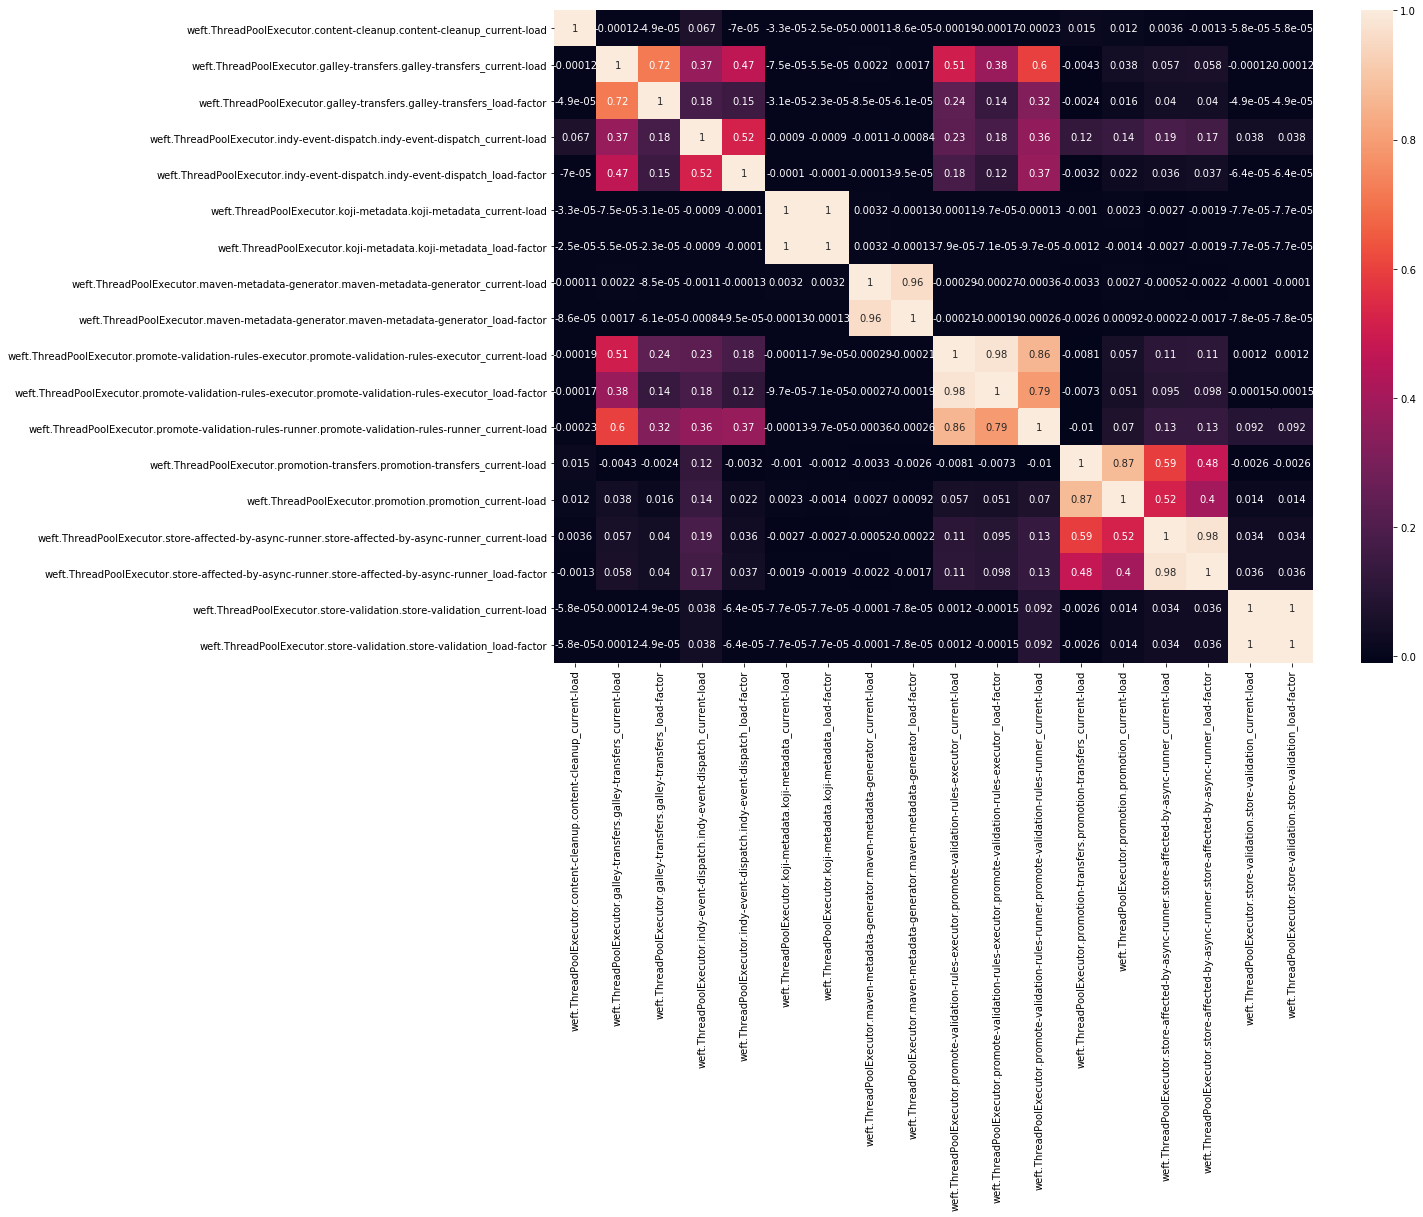

In [46]:
display(sns.heatmap(required_df[columns].corr(),annot=True))

In the above heatmap we see that each process has a high correlation with only its own current load and load factor. So we may use this data in deciding which columns are relevant.

In [47]:
final_columns.extend(['weft.ThreadPoolExecutor.content-cleanup.content-cleanup_current-load','weft.ThreadPoolExecutor.galley-transfers.galley-transfers_current-load','weft.ThreadPoolExecutor.galley-transfers.galley-transfers_load-factor','weft.ThreadPoolExecutor.indy-event-dispatch.indy-event-dispatch_current-load','weft.ThreadPoolExecutor.indy-event-dispatch.indy-event-dispatch_load-factor','weft.ThreadPoolExecutor.koji-metadata.koji-metadata_current-load','weft.ThreadPoolExecutor.maven-metadata-generator.maven-metadata-generator_current-load','weft.ThreadPoolExecutor.maven-metadata-generator.maven-metadata-generator_load-factor','weft.ThreadPoolExecutor.promote-validation-rules-executor.promote-validation-rules-executor_current-load','weft.ThreadPoolExecutor.promote-validation-rules-executor.promote-validation-rules-executor_load-factor','weft.ThreadPoolExecutor.promote-validation-rules-runner.promote-validation-rules-runner_current-load','weft.ThreadPoolExecutor.promotion-transfers.promotion-transfers_current-load','weft.ThreadPoolExecutor.promotion.promotion_current-load','weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_current-load','weft.ThreadPoolExecutor.store-affected-by-async-runner.store-affected-by-async-runner_load-factor','weft.ThreadPoolExecutor.store-validation.store-validation_current-load'])
print(len(final_columns))

40


In [48]:
for i in final_columns: 
    print(i)

o.c.i.m.healthcheck.impl.HeapHealthCheck_current-load-pct
o.c.i.m.healthcheck.impl.HeapHealthCheck_used-gb
sli.golden.content_latency
sli.golden.content_throughput
sli.golden.content.listing_latency
sli.golden.content.listing_errors
sli.golden.content.listing_throughput
sli.golden.content.maven_throughput
sli.golden.maven.download_latency
sli.golden.maven.download_throughput
sli.golden.maven.upload_latency
sli.golden.maven.upload_throughput
sli.golden.metadata_latency
sli.golden.metadata_throughput
sli.golden.metadata.maven_latency
sli.golden.metadata.maven_throughput
sli.golden.promotion_latency
sli.golden.promotion_throughput
sli.golden.promotion_load
sli.golden.repo.mgmt_latency
sli.golden.repo.mgmt_throughput
sli.golden.tracking.record_latency
sli.golden.tracking.record_throughput
sli.golden.tracking.record_load
weft.ThreadPoolExecutor.content-cleanup.content-cleanup_current-load
weft.ThreadPoolExecutor.galley-transfers.galley-transfers_current-load
weft.ThreadPoolExecutor.galley-t